In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, train_test_split

# Library used for ignore warnings
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.weight'] = 'bold'

In [2]:
df = pd.read_csv("LoanApprovalPrediction.csv")
df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2.0,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0.0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3.0,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2.0,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1.0,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


# Data Exploration:

In [3]:
df.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents           12
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           21
Loan_Amount_Term     14
Credit_History       49
Property_Area         0
Loan_Status           0
dtype: int64

In [4]:
df.shape

(598, 13)

In [5]:
df['Loan_Amount_Term'].value_counts()

Loan_Amount_Term
360.0    500
180.0     43
480.0     14
300.0     12
84.0       4
120.0      3
240.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

In [6]:
df['Credit_History'].value_counts()

Credit_History
1.0    463
0.0     86
Name: count, dtype: int64

In [7]:
df['Dependents'].value_counts()

Dependents
0.0    338
1.0    101
2.0     99
3.0     48
Name: count, dtype: int64

In [8]:
df['LoanAmount'].value_counts()

LoanAmount
120.0    20
110.0    16
100.0    15
187.0    12
128.0    11
         ..
72.0      1
240.0     1
214.0     1
59.0      1
253.0     1
Name: count, Length: 199, dtype: int64

## Handling Missing values


In [9]:
# Replace missing values in 'Dependents' and 'Credit_History' with the most frequent value
most_frequent_dependents = 0.0  # For Dependents
most_frequent_credit_history = 1.0  # For Credit_History
df['Dependents'].fillna(most_frequent_dependents, inplace=True)
df['Credit_History'].fillna(most_frequent_credit_history, inplace=True)

# Check if there are no more missing values in 'Dependents' and 'Credit_History'
print(df['Dependents'].isnull().sum())  # Should output 0
print(df['Credit_History'].isnull().sum())  # Should output 0


0
0


## Handling missing values of LoanAmount' and 'Loan_Amount_Term

- We need to decide between meadian and mean. We will visualy inspect them to see if there are any outlier since mean is sensitive to outliers and median is robust to outliers.

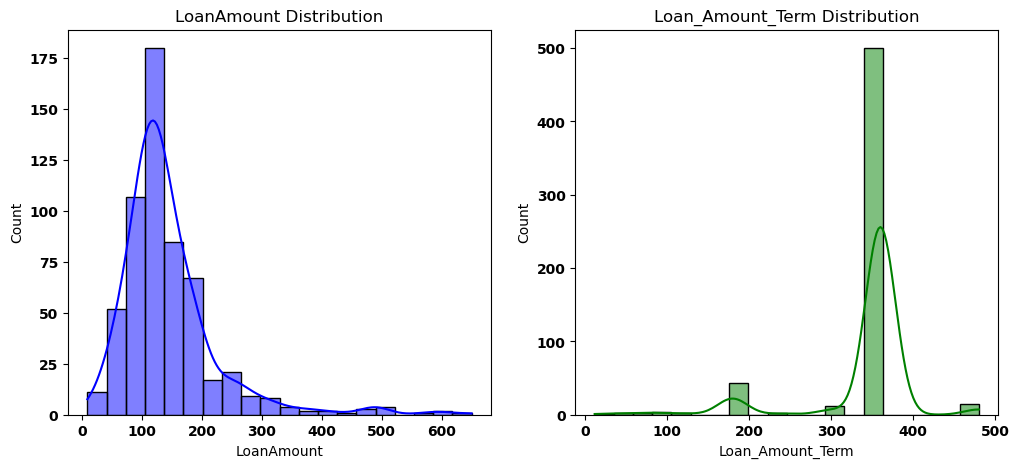

In [10]:
# Plot distributions for 'LoanAmount' and 'Loan_Amount_Term'
plt.figure(figsize=(12, 5))

# LoanAmount
plt.subplot(1, 2, 1)
sns.histplot(df['LoanAmount'], kde=True, bins=20, color='blue')
plt.title('LoanAmount Distribution')

# Loan_Amount_Term
plt.subplot(1, 2, 2)
sns.histplot(df['Loan_Amount_Term'], kde=True, bins=20, color='green')
plt.title('Loan_Amount_Term Distribution')

plt.show()


In [11]:
# Replace missing values in 'LoanAmount' with median
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)

# Replace missing values in 'Loan_Amount_Term' with median
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median(), inplace=True)

# Verify there are no more missing values
print(df.isnull().sum())


Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


## Dropping useless columns

In [12]:
# This is unique identifier of candidates in the data set, it is only useful to the company not the models.
df = df.drop(['Loan_ID'], axis=1)

In [13]:
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0.0,Graduate,No,5849,0.0,127.0,360.0,1.0,Urban,Y
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
593,Female,No,0.0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
594,Male,Yes,3.0,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
595,Male,Yes,1.0,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
596,Male,Yes,2.0,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


# Data Visualization

## Loan_Status Count

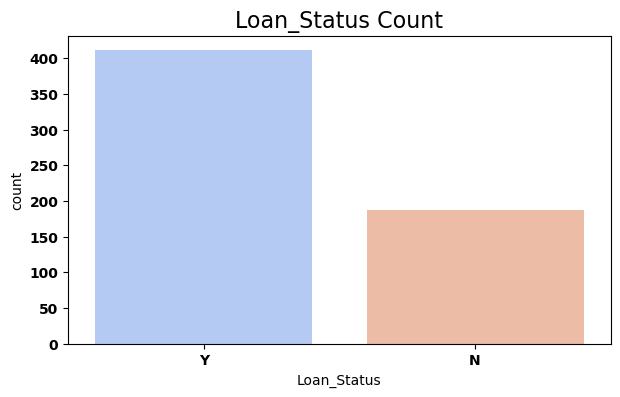

In [14]:
# Loan_Status Count
plt.figure(figsize=(7, 4))
sns.countplot(x='Loan_Status', data=df, palette='coolwarm')
plt.title('Loan_Status Count', fontsize=16)
plt.show()

## Visualization of Categorial Features

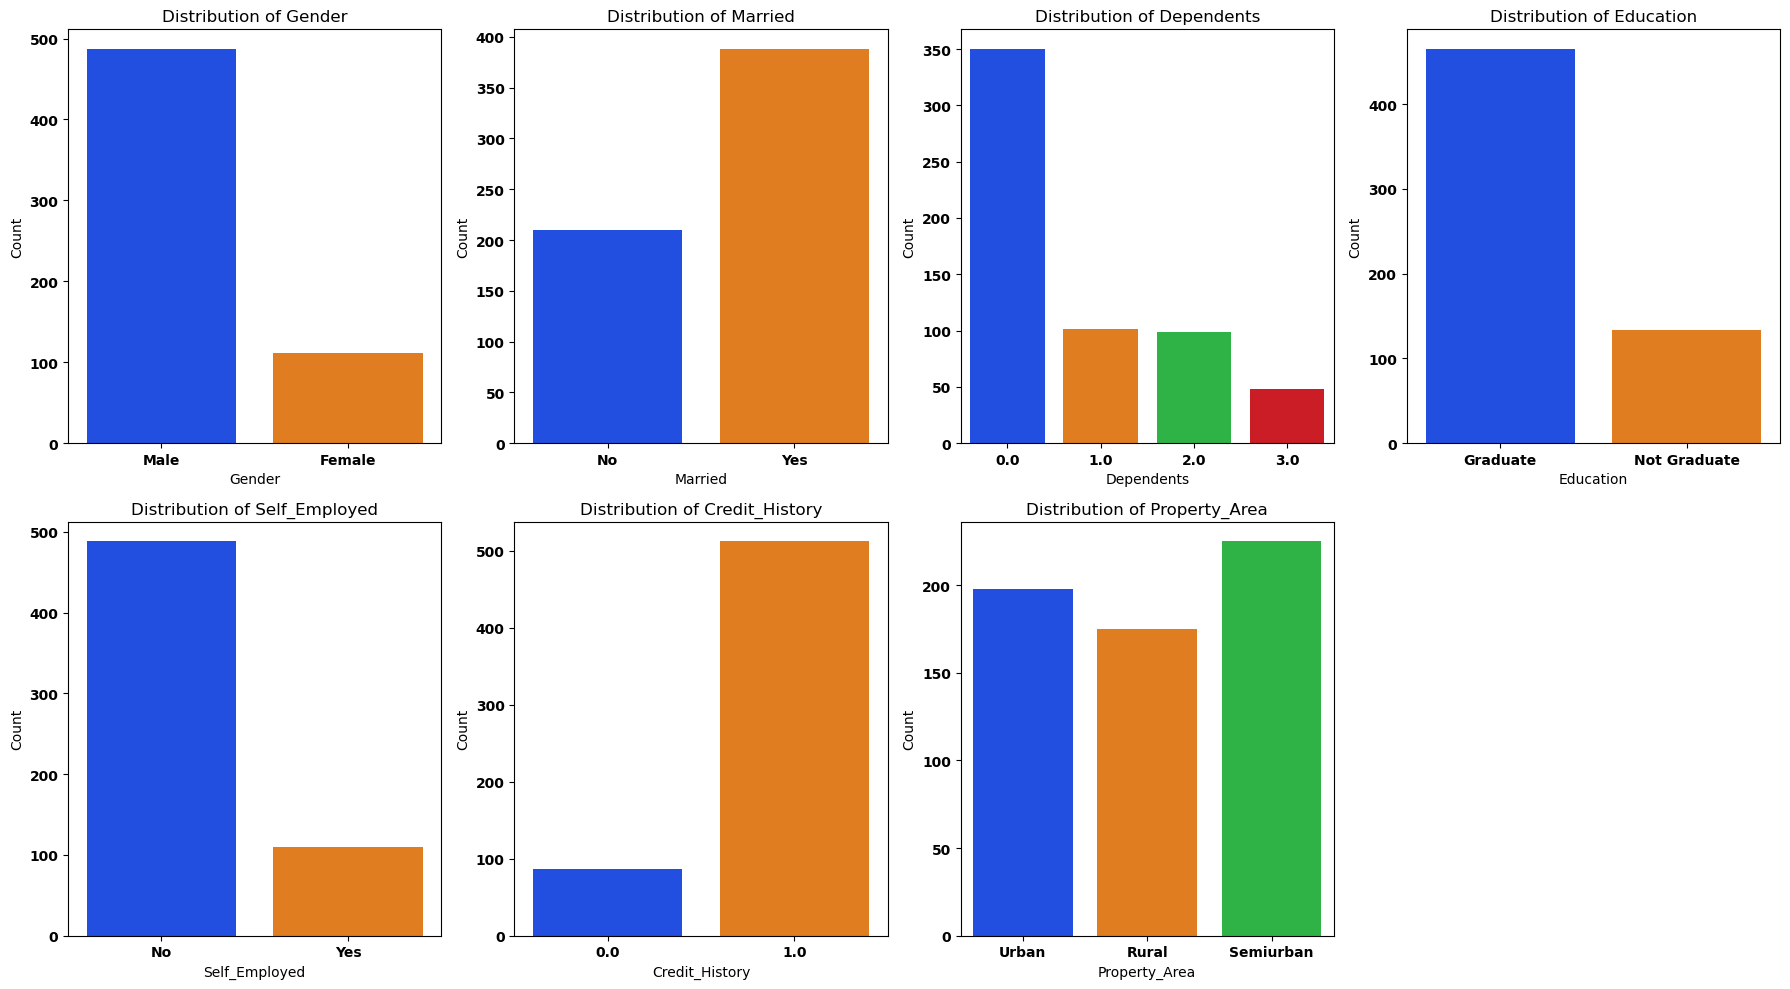

In [16]:
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 
                        'Self_Employed', 'Credit_History', 'Property_Area']

plt.figure(figsize=(18, 10))
for i, cat_feature in enumerate(categorical_features, 1):
    plt.subplot(2, 4, i)
    sns.countplot(x=cat_feature, data=df, palette='bright')
    plt.title(f"Distribution of {cat_feature}", fontsize=12)
    plt.xlabel(cat_feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Visualizing Numerical Features

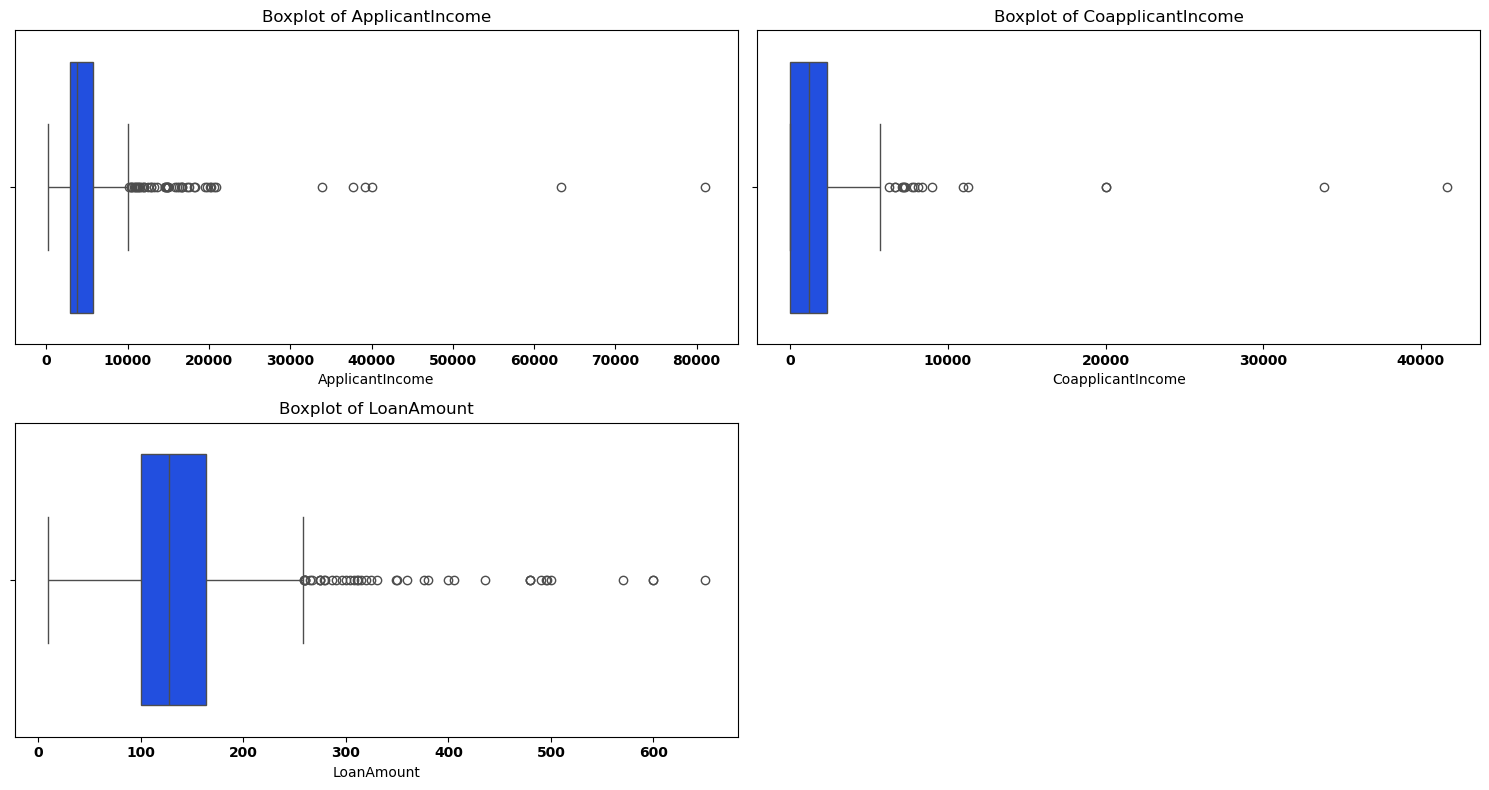

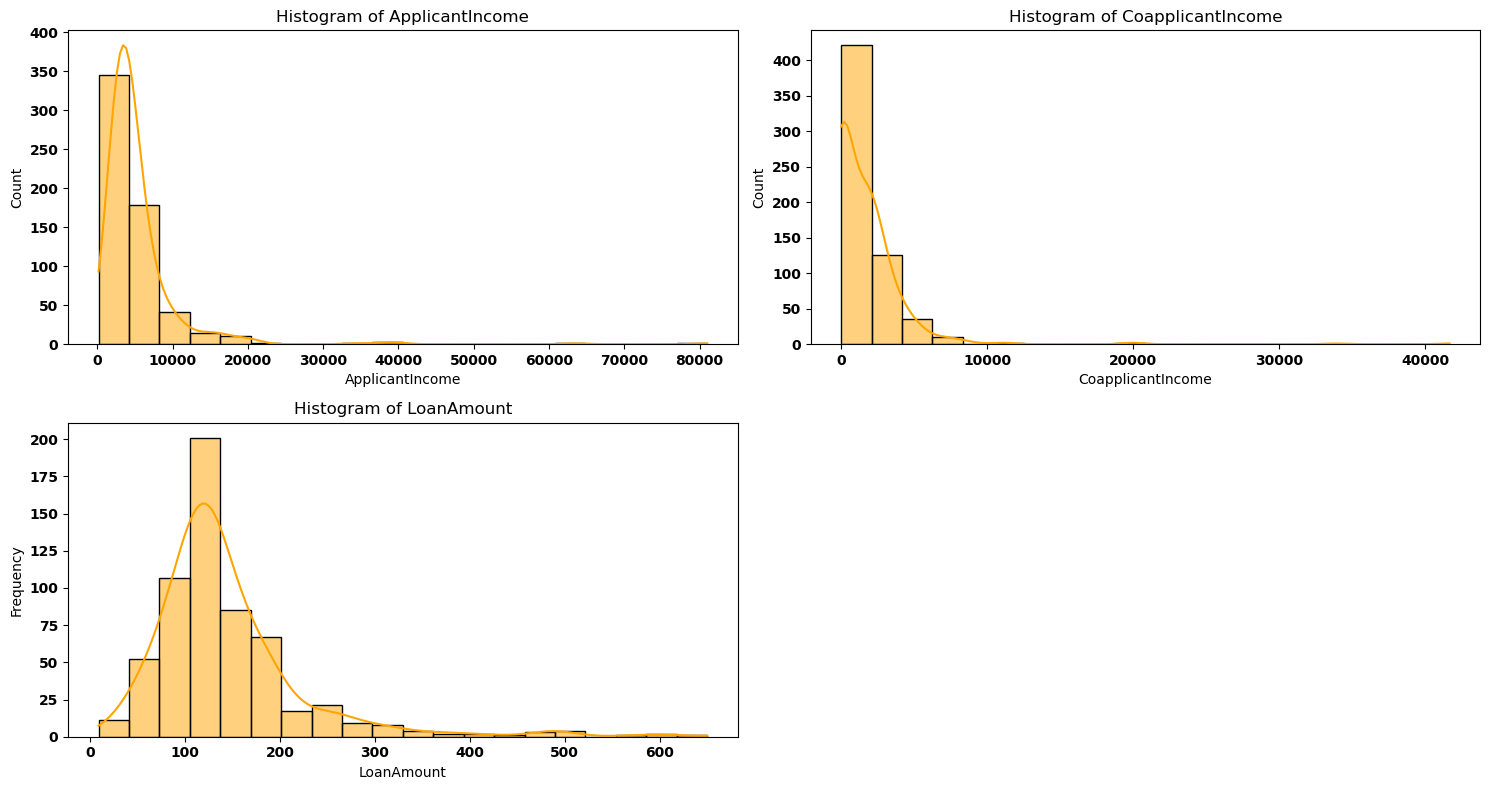

In [17]:
# Numerical Features
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

# Boxplots for numerical features
plt.figure(figsize=(15, 8))
for i, num_feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[num_feature], palette='bright')
    plt.title(f"Boxplot of {num_feature}", fontsize=12)
    plt.xlabel(num_feature)
plt.tight_layout()
plt.show()

# Distribution of numerical features
plt.figure(figsize=(15, 8))
for i, num_feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[num_feature], kde=True, color='orange', bins=20)
    plt.title(f"Histogram of {num_feature}", fontsize=12)
    plt.xlabel(num_feature)
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Feature Relationships

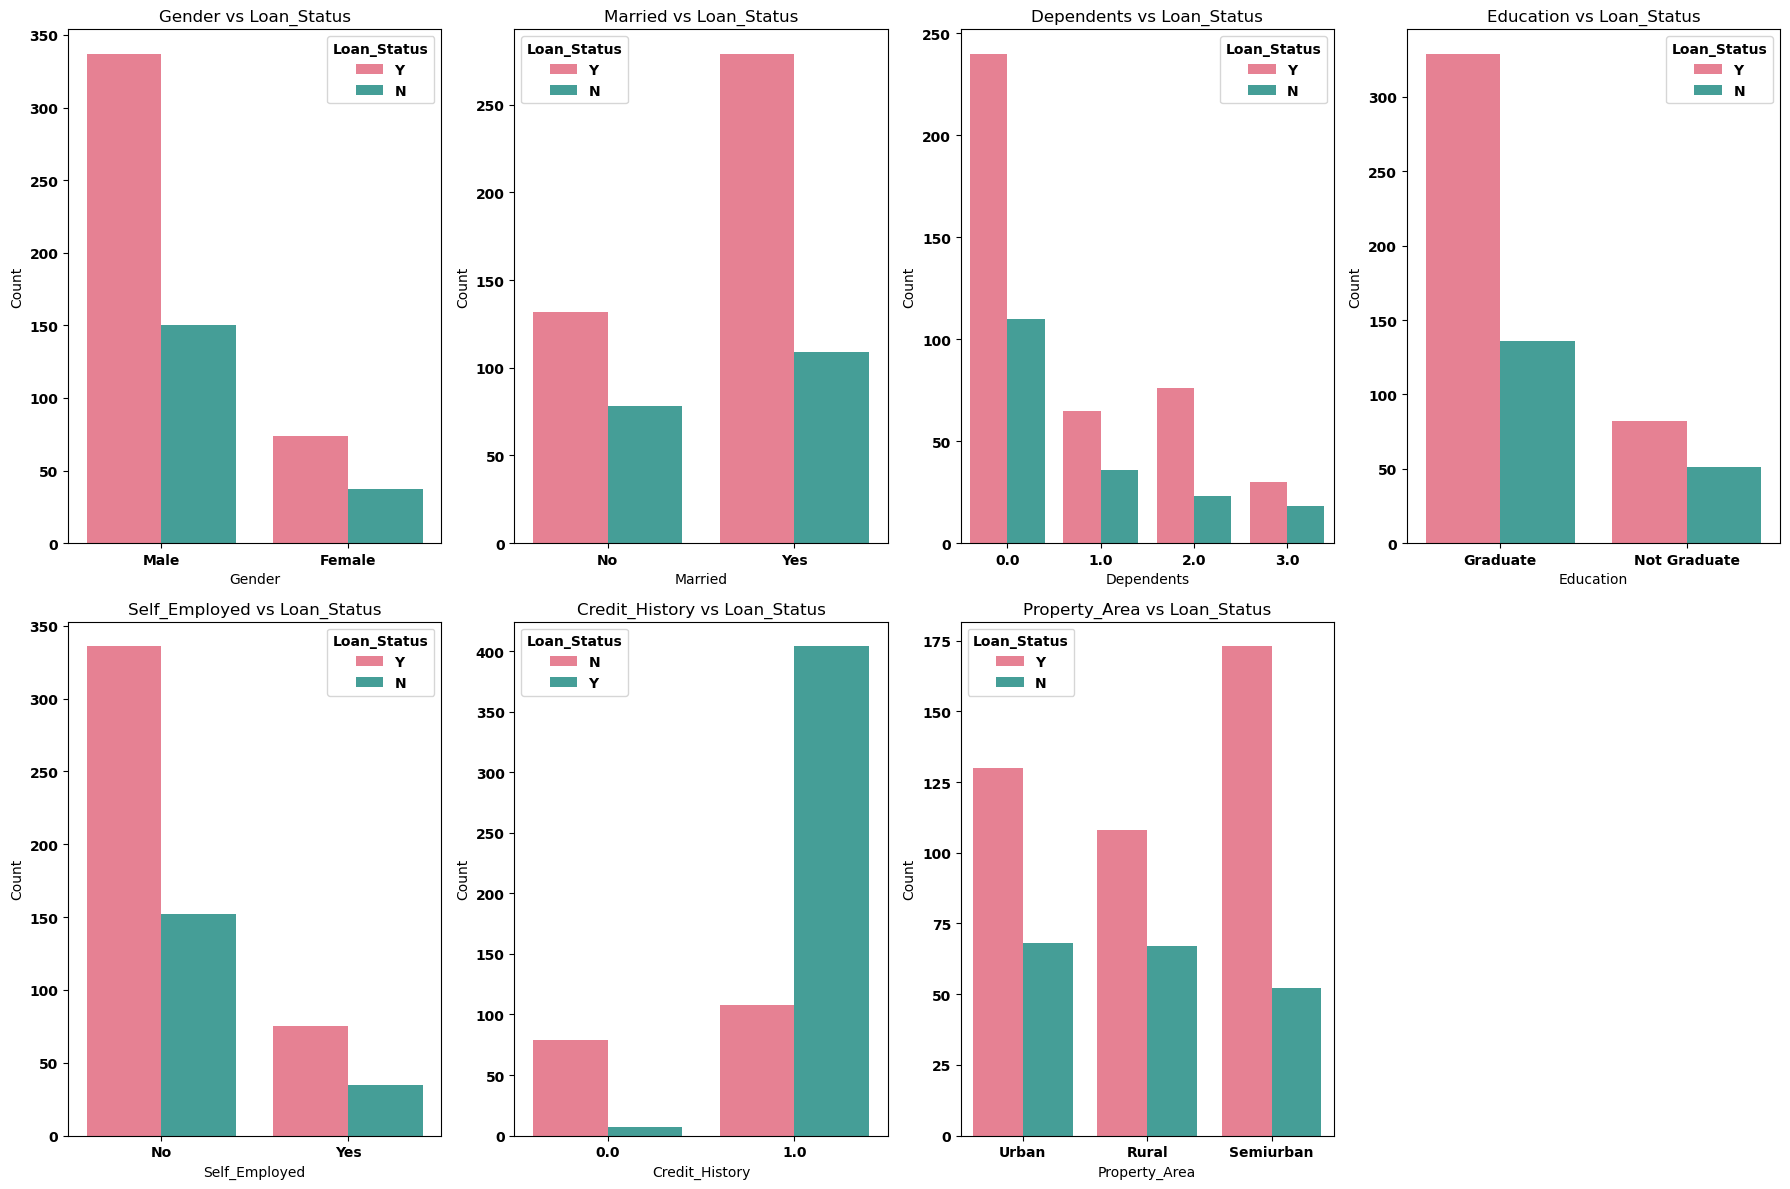

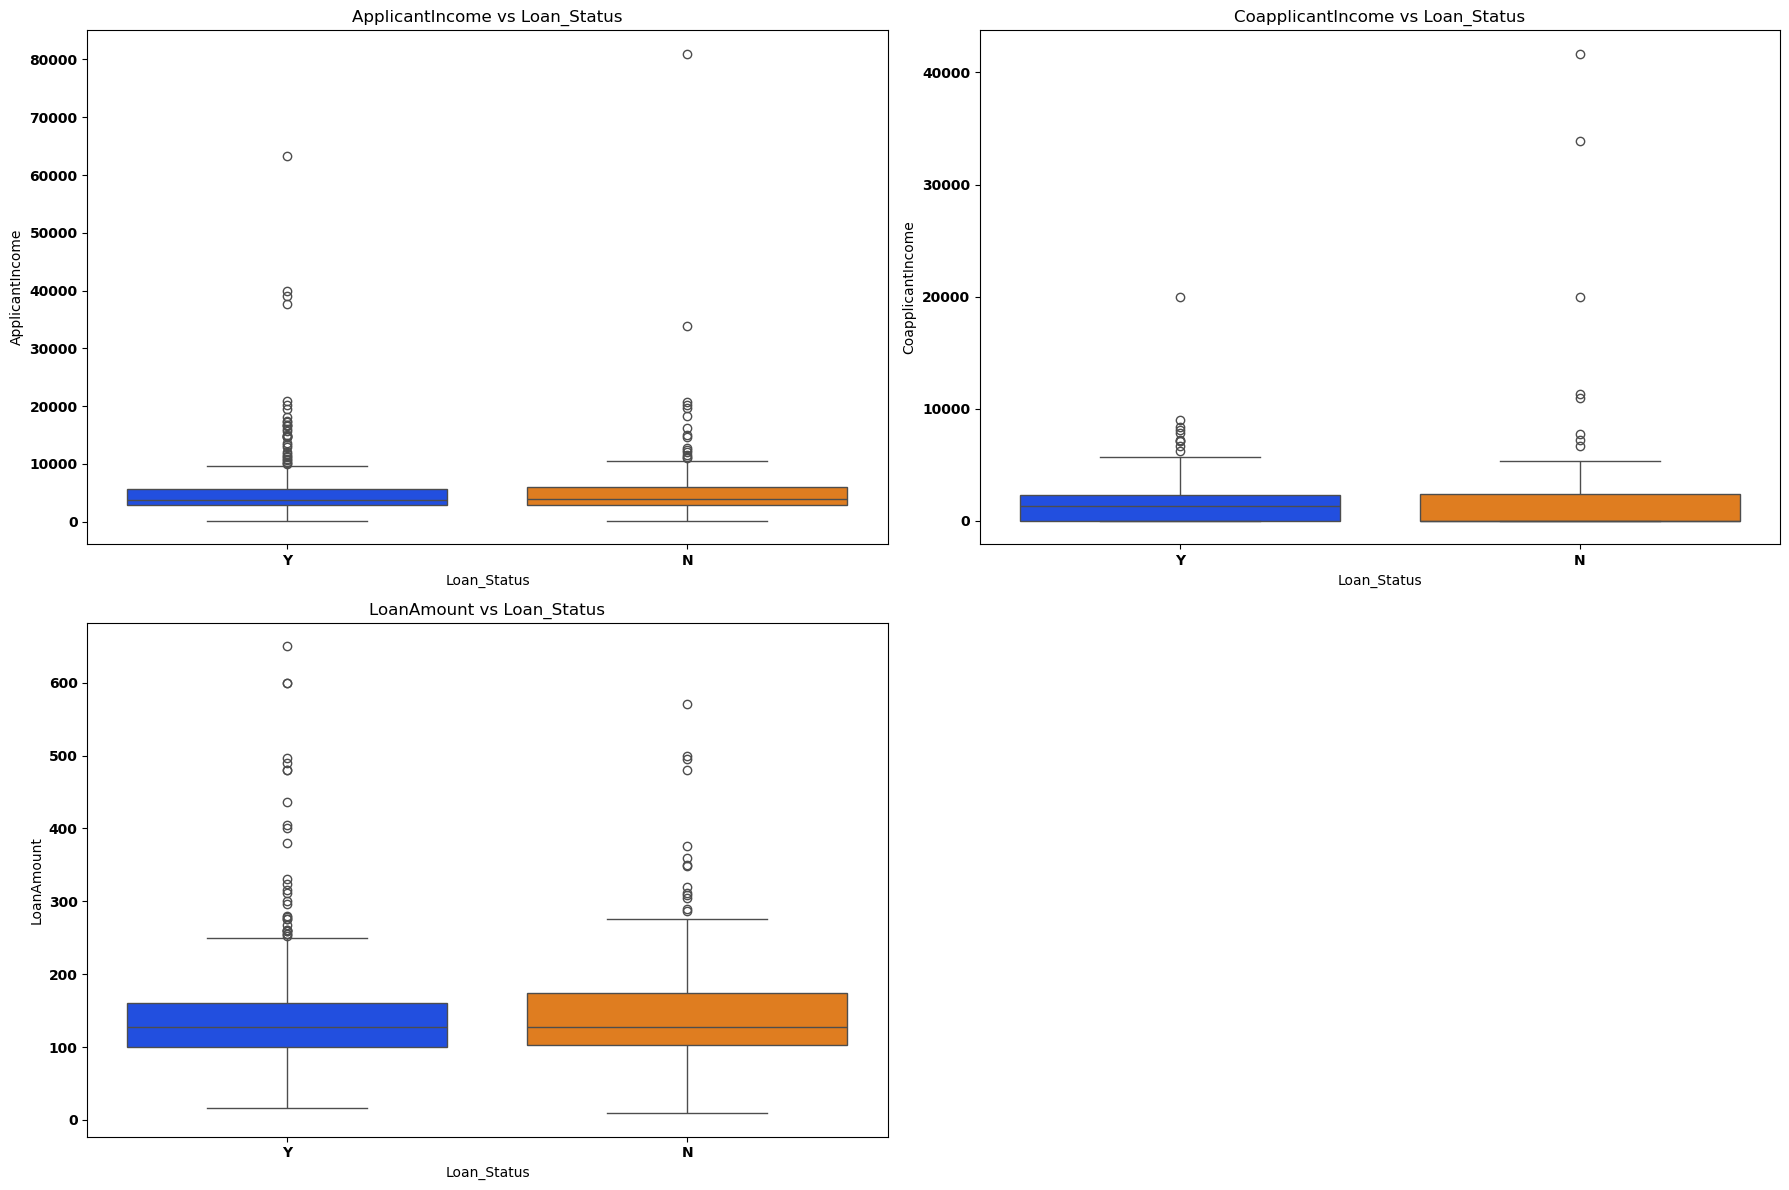

In [18]:
# Relationship between categorical features and Loan_Status
plt.figure(figsize=(18, 12))
for i, cat_feature in enumerate(categorical_features, 1):
    plt.subplot(2, 4, i)
    sns.countplot(x=cat_feature, hue='Loan_Status', data=df, palette='husl')
    plt.title(f"{cat_feature} vs Loan_Status", fontsize=12)
    plt.xlabel(cat_feature)
    plt.ylabel('Count')
plt.legend(title='Loan_Status')
plt.tight_layout()
plt.show()

# Relationship between numerical features and Loan_Status
plt.figure(figsize=(18, 12))
for i, num_feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Loan_Status', y=num_feature, data=df, palette='bright')
    plt.title(f"{num_feature} vs Loan_Status", fontsize=12)
    plt.xlabel("Loan_Status")
    plt.ylabel(num_feature)
plt.tight_layout()
plt.show()


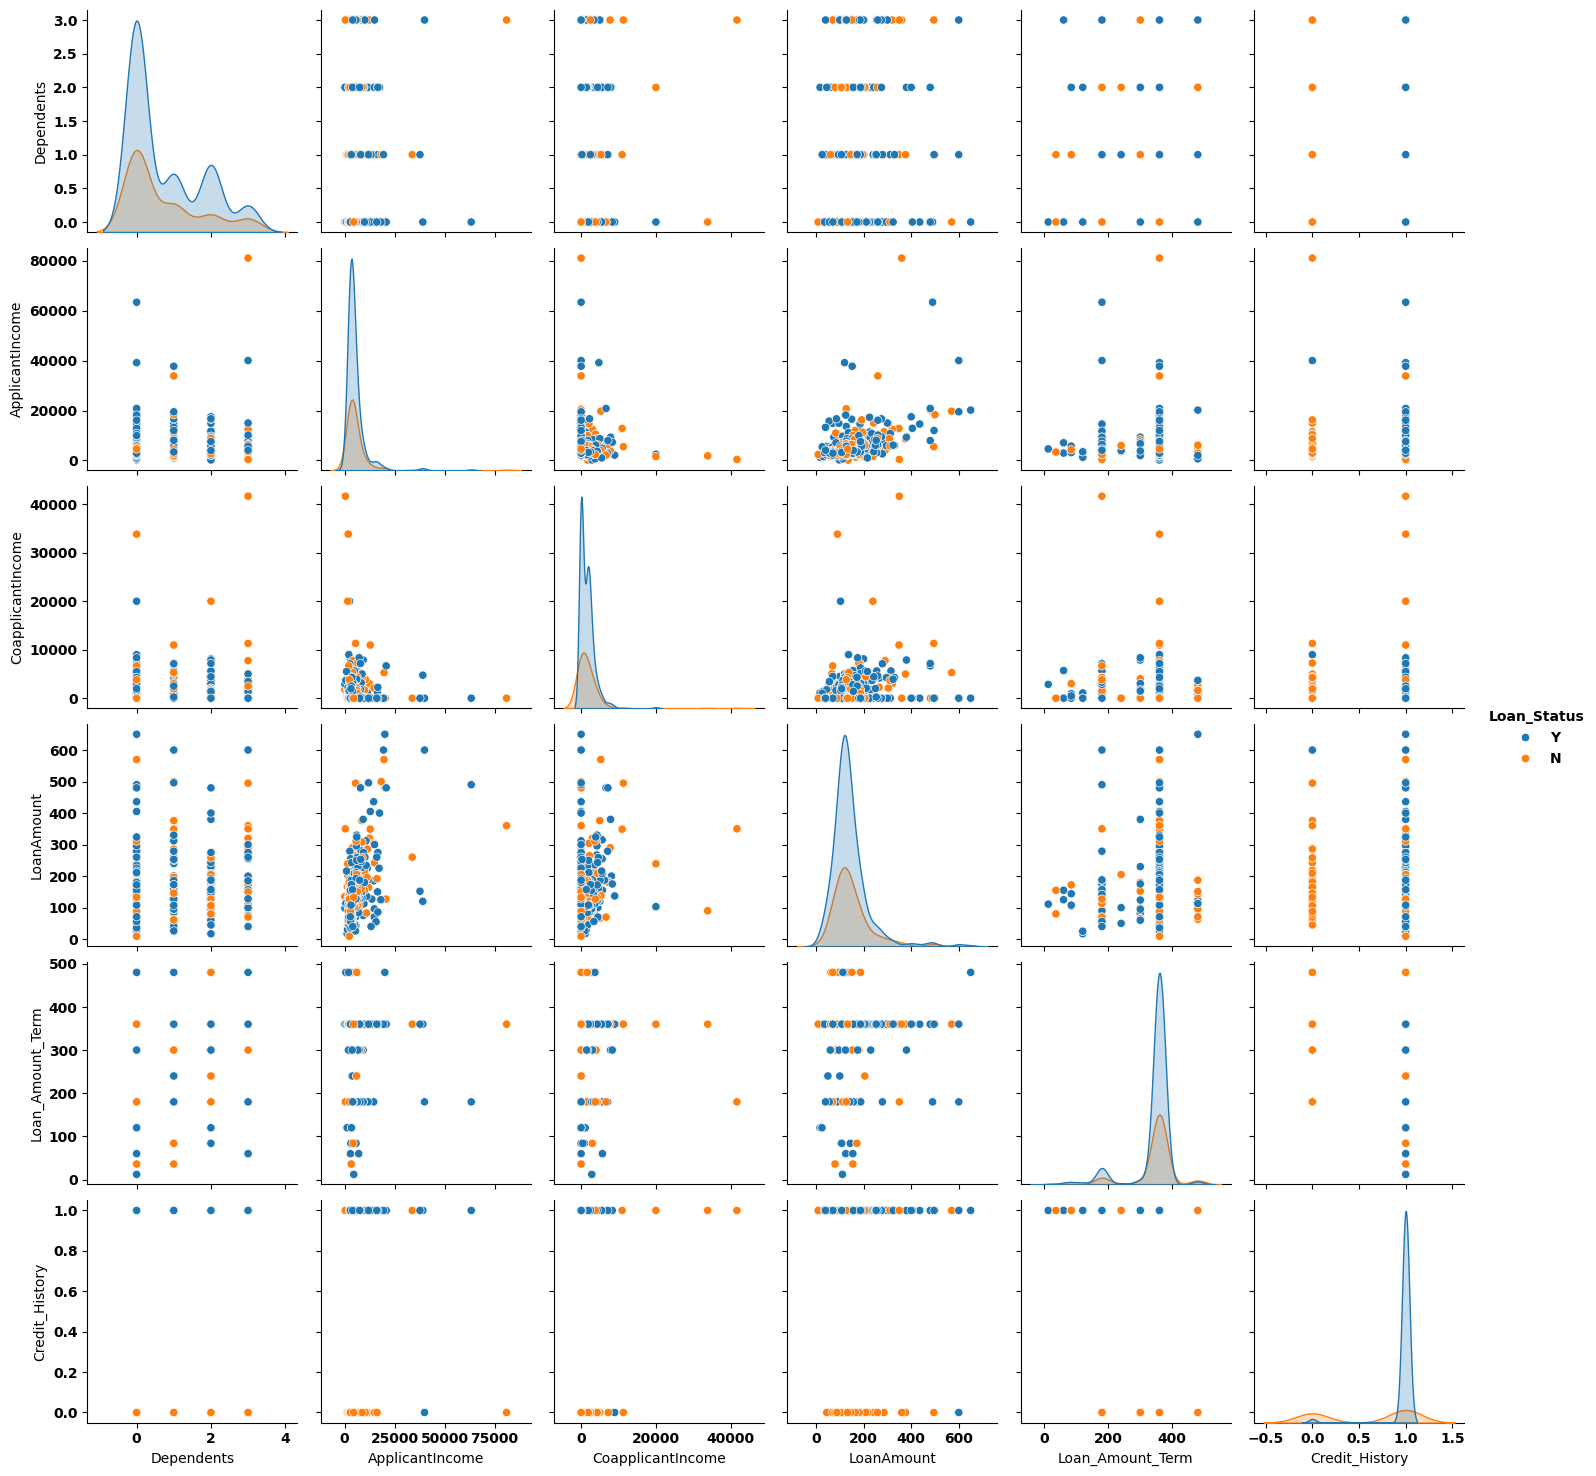

In [19]:
sns.pairplot(data=df, hue= 'Loan_Status')

## Handling Outliers

- Detecting and removing outlier is a very good method of assisting the model to use proper data that does not contain outliers which can skew the results. Models like **"Random Forest"** are robust to outliers but **"Gradient boosting"** can be sensitive to them.
- The Boxplots for numerical features on the previous visualizations highlighted that numerical columns have outliers that needs to be handled.

In [22]:
Q1 = df[numerical_features].quantile(0.25)
Q3 = df[numerical_features].quantile(0.75)
IQR = Q3 - Q1

# Detecting outliers
outliers = ((df[numerical_features] < (Q1 - 1.5 * IQR)) | (df[numerical_features] > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"Number of outliers detected: {outliers.sum()}")
df = df[~outliers] # Remove outliers from the data.
df

Number of outliers detected: 77


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0.0,Graduate,No,5849,0.0,127.0,360.0,1.0,Urban,Y
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
593,Female,No,0.0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
594,Male,Yes,3.0,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
595,Male,Yes,1.0,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
596,Male,Yes,2.0,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


## Feature Engineering

In [23]:
# Encoding the "Gender" column
df.replace({'Gender': {'Male': 0, 'Female': 1}}, inplace=True)

# Encoding the "Married" column
df.replace({'Married': {'Yes': 0, 'No': 1}}, inplace=True)

# Encoding the "Education" column
df.replace({'Education': {'Graduate': 0, 'Not Graduate': 1}}, inplace=True)

# Encoding the "Self_Employed" column
df.replace({'Self_Employed': {'Yes': 0, 'No': 1}}, inplace=True)

# Encoding the "Loan_Status" column
df.replace({'Loan_Status': {'Y': 0, 'N': 1}}, inplace=True)

# Encoding the "Property_Area" column
df.replace({'Property_Area': {'Urban': 0, 'Rural': 1, 'Semiurban': 2}}, inplace=True)

In [24]:
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,1,0.0,0,1,5849,0.0,127.0,360.0,1.0,0,0
1,0,0,1.0,0,1,4583,1508.0,128.0,360.0,1.0,1,1
2,0,0,0.0,0,0,3000,0.0,66.0,360.0,1.0,0,0
3,0,0,0.0,1,1,2583,2358.0,120.0,360.0,1.0,0,0
4,0,1,0.0,0,1,6000,0.0,141.0,360.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
593,1,1,0.0,0,1,2900,0.0,71.0,360.0,1.0,1,0
594,0,0,3.0,0,1,4106,0.0,40.0,180.0,1.0,1,0
595,0,0,1.0,0,1,8072,240.0,253.0,360.0,1.0,0,0
596,0,0,2.0,0,1,7583,0.0,187.0,360.0,1.0,0,0


In [25]:
df = pd.get_dummies(df, columns=['Dependents', 'Property_Area'], drop_first=True)

In [26]:
bool_columns = df.select_dtypes(include='bool').columns
df[bool_columns] = df[bool_columns].astype(int)
df

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_1.0,Dependents_2.0,Dependents_3.0,Property_Area_1,Property_Area_2
0,0,1,0,1,5849,0.0,127.0,360.0,1.0,0,0,0,0,0,0
1,0,0,0,1,4583,1508.0,128.0,360.0,1.0,1,1,0,0,1,0
2,0,0,0,0,3000,0.0,66.0,360.0,1.0,0,0,0,0,0,0
3,0,0,1,1,2583,2358.0,120.0,360.0,1.0,0,0,0,0,0,0
4,0,1,0,1,6000,0.0,141.0,360.0,1.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,1,1,0,1,2900,0.0,71.0,360.0,1.0,0,0,0,0,1,0
594,0,0,0,1,4106,0.0,40.0,180.0,1.0,0,0,0,1,1,0
595,0,0,0,1,8072,240.0,253.0,360.0,1.0,0,1,0,0,0,0
596,0,0,0,1,7583,0.0,187.0,360.0,1.0,0,0,1,0,0,0


## Feature Scaling

In [27]:
columns_to_scale = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

scaler = StandardScaler()

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [28]:
df

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_1.0,Dependents_2.0,Dependents_3.0,Property_Area_1,Property_Area_2
0,0,1,0,1,1.005369,-0.931213,0.034429,0.267602,1.0,0,0,0,0,0,0
1,0,0,0,1,0.304648,0.139511,0.057164,0.267602,1.0,1,1,0,0,1,0
2,0,0,0,0,-0.571530,-0.931213,-1.352392,0.267602,1.0,0,0,0,0,0,0
3,0,0,1,1,-0.802337,0.743035,-0.124714,0.267602,1.0,0,0,0,0,0,0
4,0,1,0,1,1.088947,-0.931213,0.352716,0.267602,1.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,1,1,0,1,-0.626880,-0.931213,-1.238718,0.267602,1.0,0,0,0,0,1,0
594,0,0,0,1,0.040632,-0.931213,-1.943496,-2.484126,1.0,0,0,0,1,1,0
595,0,0,0,1,2.235783,-0.760806,2.899011,0.267602,1.0,0,1,0,0,0,0
596,0,0,0,1,1.965125,-0.931213,1.398516,0.267602,1.0,0,0,1,0,0,0


## Imbalanced data

In [29]:
df['Loan_Status'].value_counts()

Loan_Status
0    363
1    158
Name: count, dtype: int64

- It is clear from the data that classes of "Loan_Status" are not balanced. Therefore, this case can cause the model to be biased. This can be handled by balancing the data by "Resampling," creating synthetic data for the minority class. [https://www.geeksforgeeks.org/introduction-to-resampling-methods/]

In [30]:
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

smote = SMOTE(random_state=42)
X_synthetic, y_synthetic = smote.fit_resample(X, y)

# Compare the classes
print(y_synthetic.value_counts())

Loan_Status
0    363
1    363
Name: count, dtype: int64


## Splitting Data

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (580, 14)
Testing set shape: (146, 14)


# Models and Evaluation

In [32]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

print("Random Forest Results:")
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))
print("Accuracy:", accuracy_score(y_test, rf_predictions))

Random Forest Results:
[[74  6]
 [13 53]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        80
           1       0.90      0.80      0.85        66

    accuracy                           0.87       146
   macro avg       0.87      0.86      0.87       146
weighted avg       0.87      0.87      0.87       146

Accuracy: 0.8698630136986302


In [33]:
# Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

gb_predictions = gb_model.predict(X_test)

print("Gradient Boosting Results:")
print(confusion_matrix(y_test, gb_predictions))
print(classification_report(y_test, gb_predictions))
print("Accuracy:", accuracy_score(y_test, gb_predictions))

Gradient Boosting Results:
[[65 15]
 [20 46]]
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        80
           1       0.75      0.70      0.72        66

    accuracy                           0.76       146
   macro avg       0.76      0.75      0.76       146
weighted avg       0.76      0.76      0.76       146

Accuracy: 0.7602739726027398


In [34]:
# XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

print("XGBoost Results:")
print(confusion_matrix(y_test, xgb_predictions))
print(classification_report(y_test, xgb_predictions))
print("Accuracy:", accuracy_score(y_test, xgb_predictions))

XGBoost Results:
[[64 16]
 [14 52]]
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        80
           1       0.76      0.79      0.78        66

    accuracy                           0.79       146
   macro avg       0.79      0.79      0.79       146
weighted avg       0.80      0.79      0.79       146

Accuracy: 0.7945205479452054


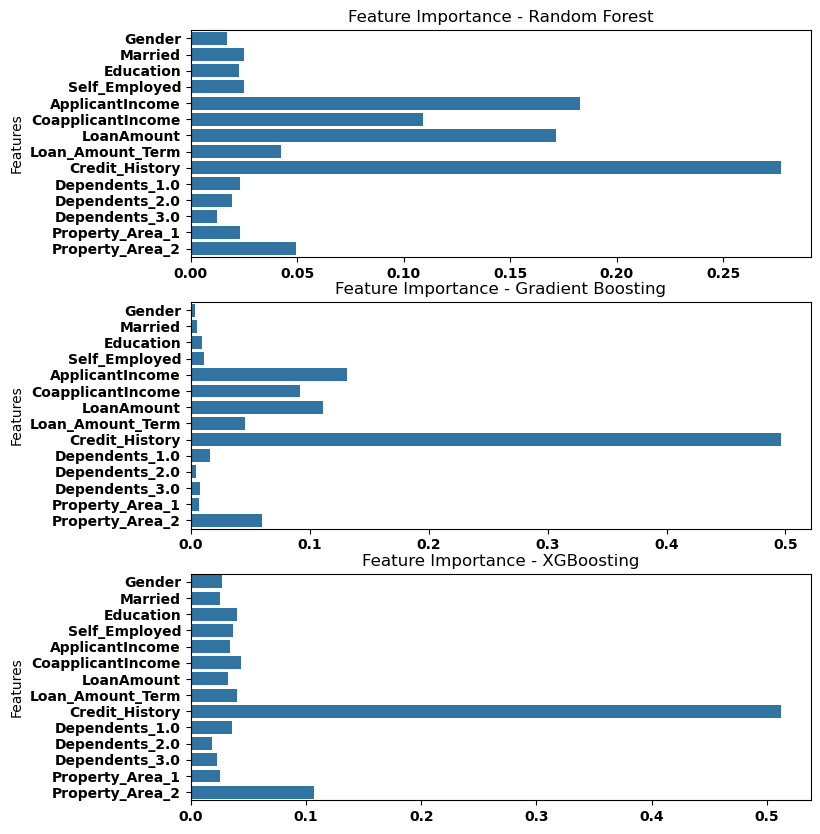

In [35]:
# Contribution of features to Random Forest
feature_importance_rf = rf_model.feature_importances_
features = X.columns

# Contribution of features to Gradient Boosting
feature_importance_gb = gb_model.feature_importances_
features = X.columns

# Contribution of features to XGBoosting
feature_importance_xgb = xgb_model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 10))
plt.subplot(3, 1, 1)
sns.barplot(x=feature_importance_rf, y=features)
plt.title('Feature Importance - Random Forest')
plt.ylabel("Features")

plt.subplot(3, 1, 2)
sns.barplot(x=feature_importance_gb, y=features)
plt.title('Feature Importance - Gradient Boosting')
plt.ylabel("Features")

plt.subplot(3, 1, 3)
sns.barplot(x=feature_importance_xgb, y=features)
plt.title('Feature Importance - XGBoosting')
plt.ylabel("Features")

plt.show()

In [36]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
rf_tuning = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
rf_tuning.fit(X_train, y_train)


print("Best Parameters:", rf_tuning.best_params_)
print("Best Accuracy:", rf_tuning.best_score_)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.8155172413793104


In [37]:
best_rf_model = rf_tuning.best_estimator_

# Predictions on test data with best parameters
rf_predictions = best_rf_model.predict(X_test)

print("\nRandom Forest Results:")
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))
print("Test Accuracy:", accuracy_score(y_test, rf_predictions))


Random Forest Results:
[[74  6]
 [11 55]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        80
           1       0.90      0.83      0.87        66

    accuracy                           0.88       146
   macro avg       0.89      0.88      0.88       146
weighted avg       0.88      0.88      0.88       146

Test Accuracy: 0.8835616438356164


# Conclusion
- In conclusion, we made a comparative study of three models: Random Forest, Gradient Boosting, and XG Boosting.
- Random Forest performed well compared to the other two models, followed by XG Boosting.
- Hyperparameter tuning was performed on Random forest to improve its accuracy from 0.8698 to 0.8835.